# Data Integration for Building Information Modeling

This notebook demonstrates the process of converting raw building information data (IFC files and PDF documents) into RDF graph format for further processing with Graph RAG (Retrieval Augmented Generation).

**What we'll accomplish:**
- Process IFC (Industry Foundation Classes) building models into semantic graphs
- Convert PDF product documentation into linked data format
- Analyze and visualize the results
- Prepare the data for graph-based knowledge retrieval

## 0. Setup
This notebook can run in either Google Colab or locally. The setup cell will automatically configure your environment.

In [56]:
import os
from pathlib import Path

# Detect environment
try:
    from IPython import get_ipython
    IN_COLAB = 'google.colab' in str(get_ipython())
except:
    IN_COLAB = False

# Configure environment
if IN_COLAB:
    !git clone https://github.com/qaecy/bilt2025.git
    %cd bilt2025
    requirements_path = "requirements.txt"
    from google.colab import userdata
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
else:    
    # Find requirements.txt based on current directory
    current_dir = Path().resolve()
    requirements_path = "../requirements.txt" if current_dir.name == "notebooks" else "requirements.txt"
    print(f"Looking for requirements at: {Path(requirements_path).resolve()}")

# Install dependencies if requirements.txt exists
if os.path.exists(requirements_path):
    %pip install -r {requirements_path}
    if IN_COLAB:
        %pip install -e .
    print("✓ Environment setup complete")
else:
    print("⚠️ Could not find requirements.txt")

Looking for requirements at: /Users/christianfrausing/dev/bilt2025/requirements.txt

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
✓ Environment setup complete


## Prerequisites

This notebook automatically installs all required packages from `requirements.txt` when running the setup cell above. The key libraries include data processing tools (pandas, rdflib), visualization tools (matplotlib), and domain-specific processors for IFC (ifcopenshell) and PDF (pymupdf) files.

# TODO update flow as we also have ttl to embedding

## Data Flow Overview

```
┌───────────────┐     ┌─────────────────┐     ┌────────────────┐     ┌─────────────────┐
│  Input Data   │     │   Converters    │     │  Output Data   │     │     Analysis    │
├───────────────┤ --> ├─────────────────┤ --> ├────────────────┤ --> ├─────────────────┤
│  IFC Files    │     │ ifc_converter   │     │      RDF       │     │ Triple Count    │
│  PDF Files    │     │ pdf_converter   │     │  (Turtle fmt)  │     │ Size Comparison │
└───────────────┘     └─────────────────┘     └────────────────┘     └─────────────────┘
                                                                              ↓
                                                             ┌─────────────────────────┐
                                                             │  Graph RAG (Next Lab)   │
                                                             └─────────────────────────┘
```

## 1. Import Libraries

In [57]:
import sys
import time
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from rdflib import Graph

# Add project to path if running locally
if not IN_COLAB:
    project_root = Path().resolve()
    if project_root.name == 'notebooks':
        project_root = project_root.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))

# Import converters
from src.graph_converter.ifc_converter import ifc_to_ttl
from src.graph_converter.pdf_converter import pdf_to_ttl
from src.graph_converter.embedding_converter import ttl_to_embeddings

## 2. Define Data Paths

Next, we'll set up the paths for our raw data and output directories.

In [58]:
# Define paths with consistent approach for Colab and local environments
project_root = Path().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent

DATA_DIR = project_root / "data"
RAW_DIR = DATA_DIR / "raw" / "buildingsmart_duplex"
GRAPH_DIR = DATA_DIR / "graph" / "buildingsmart_duplex"
EMBEDDINGS_DIR = DATA_DIR / "embeddings" / "buildingsmart_duplex"

# Ensure directories exist
for dir_path in [RAW_DIR, GRAPH_DIR, EMBEDDINGS_DIR]:
    dir_path.mkdir(exist_ok=True)

print(f"Raw data: {RAW_DIR}\nOutput directory: {GRAPH_DIR}")

Raw data: /Users/christianfrausing/dev/bilt2025/data/raw/buildingsmart_duplex
Output directory: /Users/christianfrausing/dev/bilt2025/data/graph/buildingsmart_duplex


## 3. List Available Data Files

Let's examine the available data files - IFC files contain 3D building models, while PDF files contain product specifications.

In [59]:
# List and display available files
ifc_files = list(RAW_DIR.glob("*.ifc"))
pdf_files = list(RAW_DIR.glob("*.pdf"))

# Create DataFrame with file information
file_info = [{
    "Filename": file.name,
    "Type": file.suffix[1:].upper(),
    "Size (MB)": round(file.stat().st_size / (1024 * 1024), 2)
} for file in ifc_files + pdf_files]

file_df = pd.DataFrame(file_info).sort_values(["Type", "Size (MB)"], ascending=[True, False])
display(file_df)

,Filename,Type,Size (MB)
0,Duplex_M_20111024_ROOMS_AND_SPACES.ifc,IFC,8.38
1,Duplex_A_20110907.ifc,IFC,2.27
2,Duplex_Electrical_20121207.ifc,IFC,1.53
9,1250x2010Door_ProductData.pdf,PDF,5.03
3,0813x2420Door_ProductData.pdf,PDF,1.19
6,0762x2032Door_ProductData.pdf,PDF,0.50
10,Window819x759_ProductData.pdf,PDF,0.40
5,SmokeDetector-ProductData.pdf,PDF,0.23
7,SmallCoffeeTable-ProductData.pdf,PDF,0.22
8,0864x2032Door_ProductData.pdf,PDF,0.05


## 4. Processing IFC Files

We'll convert IFC files to RDF/Turtle format using a converter that maps building elements to a semantic graph. The function includes caching to avoid redundant processing.

In [60]:
def process_files(files, converter_func, output_dir, output_format, force_reprocess=False):
    """Process files to TTL format with caching
    
    Args:
        files: List of files to process
        converter_func: Function to convert files to TTL
        output_dir: Directory to save TTL files
        force_reprocess: Whether to regenerate existing TTL files
    """
    results = []
    
    for file in files:
        output_file = output_dir / f"{file.stem}.{output_format}"
        
        # Use cache if file exists and not forced to reprocess
        if output_file.exists() and not force_reprocess:
            print(f"✓ Using cached {file.name}")
            results.append({
                "Filename": file.name,
                "Status": "Cached",
                "Processing Time": "N/A",
                "Output Size (MB)": round(output_file.stat().st_size / (1024 * 1024), 2)
            })
            continue
        
        try:
            print(f"Processing {file.name}...")
            start_time = time.time()
            converter_func(str(file), str(output_file))            
            processing_time = round(time.time() - start_time, 2)
            print(f"✓ Processed {file.name} in {processing_time} seconds")
            
            results.append({
                "Filename": file.name,
                "Status": "Success",
                "Processing Time": f"{processing_time} sec",
                "Output Size (MB)": round(output_file.stat().st_size / (1024 * 1024), 2)
            })
            
        except Exception as e:
            print(f"❌ Error processing {file.name}: {str(e)}")
            results.append({
                "Filename": file.name,
                "Status": f"Error: {str(e)[:50]}...",
                "Processing Time": "N/A",
                "Output Size (MB)": "N/A"
            })
    
    return pd.DataFrame(results)

# Process IFC files
ifc_results = process_files(ifc_files, ifc_to_ttl, GRAPH_DIR, "ttl", force_reprocess=False)
display(ifc_results)

✓ Using cached Duplex_M_20111024_ROOMS_AND_SPACES.ifc
✓ Using cached Duplex_A_20110907.ifc
✓ Using cached Duplex_Electrical_20121207.ifc


,Filename,Status,Processing Time,Output Size (MB)
0,Duplex_M_20111024_ROOMS_AND_SPACES.ifc,Cached,N/A,3.14
1,Duplex_A_20110907.ifc,Cached,N/A,1.44
2,Duplex_Electrical_20121207.ifc,Cached,N/A,0.48


## 5. Processing PDF Documents

Similarly, we'll process PDF files that contain product specifications to complement the geometric data in IFC files.

In [61]:
# Process PDF files using the same utility function
pdf_results = process_files(pdf_files, pdf_to_ttl, GRAPH_DIR, "ttl", force_reprocess=False)
display(pdf_results)

✓ Using cached 0813x2420Door_ProductData.pdf
✓ Using cached LargeCoffeeTeble_ProductInfo.pdf
✓ Using cached SmokeDetector-ProductData.pdf
✓ Using cached 0762x2032Door_ProductData.pdf
✓ Using cached SmallCoffeeTable-ProductData.pdf
✓ Using cached 0864x2032Door_ProductData.pdf
✓ Using cached 1250x2010Door_ProductData.pdf
✓ Using cached Window819x759_ProductData.pdf


,Filename,Status,Processing Time,Output Size (MB)
0,0813x2420Door_ProductData.pdf,Cached,N/A,0.07
1,LargeCoffeeTeble_ProductInfo.pdf,Cached,N/A,0.00
2,SmokeDetector-ProductData.pdf,Cached,N/A,0.02
3,0762x2032Door_ProductData.pdf,Cached,N/A,0.08
4,SmallCoffeeTable-ProductData.pdf,Cached,N/A,0.01
5,0864x2032Door_ProductData.pdf,Cached,N/A,0.01
6,1250x2010Door_ProductData.pdf,Cached,N/A,0.00
7,Window819x759_ProductData.pdf,Cached,N/A,0.07


## 6. Analysis of Processed Data

Let's analyze the resulting RDF graphs, comparing metrics between IFC and PDF sources.

,Filename,Source Type,Size (MB),Triple Count
7,Duplex_M_20111024_ROOMS_AND_SPACES.ttl,IFC,3.14,92565
3,Duplex_A_20110907.ttl,IFC,1.44,41052
2,Duplex_Electrical_20121207.ttl,IFC,0.48,16391
9,0762x2032Door_ProductData.ttl,PDF,0.08,843
6,Window819x759_ProductData.ttl,PDF,0.07,699
0,0813x2420Door_ProductData.ttl,PDF,0.07,684
8,SmokeDetector-ProductData.ttl,PDF,0.02,165
10,SmallCoffeeTable-ProductData.ttl,PDF,0.01,81
4,0864x2032Door_ProductData.ttl,PDF,0.01,69
1,LargeCoffeeTeble_ProductInfo.ttl,PDF,0.00,35


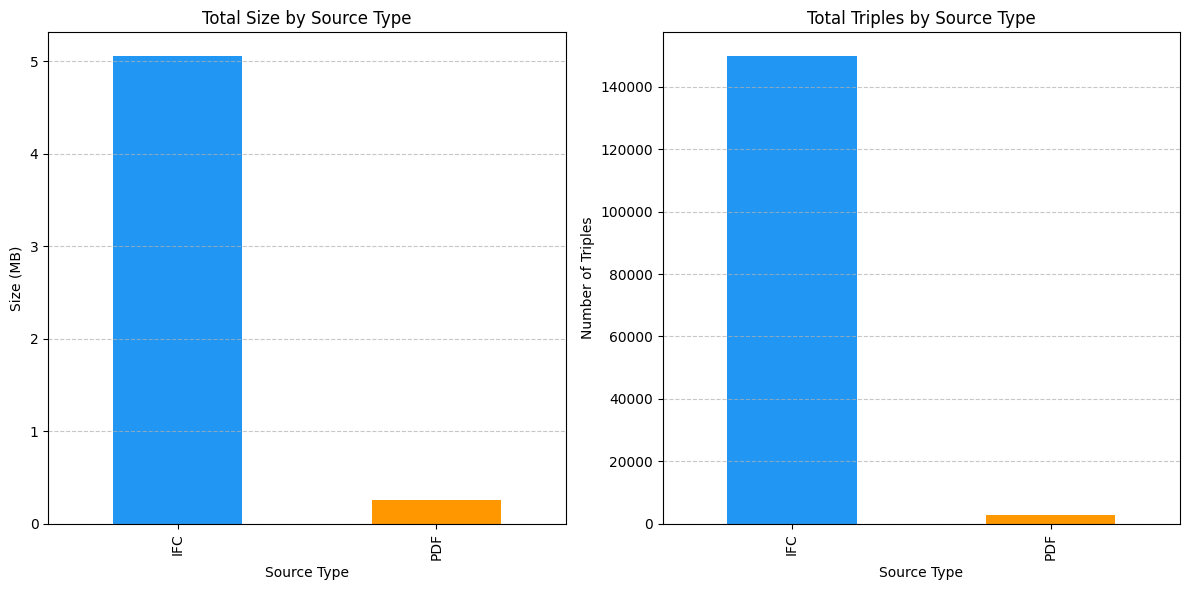

,Metric,IFC Total,PDF Total,Ratio (IFC:PDF)
0,Size (MB),5.06,0.26,19.46:1
1,Triple Count,150008.00,2608.00,57.52:1


This comparison shows how IFC files typically generate much richer semantic data compared to PDF documents.


In [62]:
# Analyze processed files
ttl_files = list(GRAPH_DIR.glob("*.ttl"))

# Function to safely load and analyze a graph file
def analyze_graph(ttl_file, ifc_stems):
    try:
        g = Graph()
        g.parse(str(ttl_file), format="turtle")
        source_type = "IFC" if ttl_file.stem in ifc_stems else "PDF"
        return {
            "Filename": ttl_file.name,
            "Source Type": source_type,
            "Size (MB)": round(ttl_file.stat().st_size / (1024 * 1024), 2),
            "Triple Count": len(g)
        }
    except Exception as e:
        print(f"Error analyzing {ttl_file.name}: {str(e)}")
        return {
            "Filename": ttl_file.name,
            "Source Type": "Unknown",
            "Size (MB)": round(ttl_file.stat().st_size / (1024 * 1024), 2),
            "Triple Count": 0
        }

# Get list of IFC file stems for source type detection
ifc_stems = [ifc.stem for ifc in ifc_files]

# Gather information about all TTL files
graph_info = [analyze_graph(ttl_file, ifc_stems) for ttl_file in ttl_files]
graph_df = pd.DataFrame(graph_info).sort_values(["Source Type", "Triple Count"], ascending=[True, False])
display(graph_df)

# Visualize comparison between IFC and PDF data
plt.figure(figsize=(12, 6))

# Size comparison
plt.subplot(1, 2, 1)
graphs_by_source = graph_df.groupby("Source Type")["Size (MB)"].sum()
graphs_by_source.plot(kind="bar", color=["#2196F3", "#FF9800"])
plt.title("Total Size by Source Type")
plt.ylabel("Size (MB)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Triple count comparison
plt.subplot(1, 2, 2)
triples_by_source = graph_df.groupby("Source Type")["Triple Count"].sum()
triples_by_source.plot(kind="bar", color=["#2196F3", "#FF9800"])
plt.title("Total Triples by Source Type")
plt.ylabel("Number of Triples")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Create ratio comparison DataFrame
try:
    # Calculate size and triple ratios
    size_by_type = graphs_by_source.to_dict()
    triples_by_type = triples_by_source.to_dict()
    
    # Only calculate ratios if both IFC and PDF data exist
    if 'IFC' in size_by_type and 'PDF' in size_by_type and size_by_type['PDF'] > 0:
        size_ratio = f"{size_by_type['IFC'] / size_by_type['PDF']:.2f}:1"
    else:
        size_ratio = "N/A"
        
    if 'IFC' in triples_by_type and 'PDF' in triples_by_type and triples_by_type['PDF'] > 0:
        triple_ratio = f"{triples_by_type['IFC'] / triples_by_type['PDF']:.2f}:1"
    else:
        triple_ratio = "N/A"
    
    # Create ratio comparison DataFrame
    ratio_data = {
        'Metric': ['Size (MB)', 'Triple Count'],
        'IFC Total': [size_by_type.get('IFC', 0), triples_by_type.get('IFC', 0)],
        'PDF Total': [size_by_type.get('PDF', 0), triples_by_type.get('PDF', 0)],
        'Ratio (IFC:PDF)': [size_ratio, triple_ratio]
    }
    
    display(pd.DataFrame(ratio_data))
    print("This comparison shows how IFC files typically generate much richer semantic data compared to PDF documents.")
    
except Exception as e:
    print(f"Error calculating ratios: {str(e)}")

## 7. Sample Triple Analysis

Let's examine sample triples to understand the structure of our semantic graphs.

In [63]:
def analyze_sample_triples(file_path, sample_size=10):
    """Display sample triples and namespace information from an RDF file"""
    g = Graph()
    g.parse(str(file_path), format="turtle")
    
    print(f"Analyzing {file_path.name} - Total triples: {len(g)}")
    
    # Show namespaces
    print("\nNamespaces:")
    for prefix, namespace in g.namespaces():
        print(f"  {prefix}: {namespace}")
    
    # Show sample triples
    print(f"\nSample triples:")
    for i, (s, p, o) in enumerate(list(g)[:sample_size]):
        print(f"  {i+1}. {s} → {p} → {o}")
        
# Sample one IFC and one PDF file
ifc_sample = next((f for f in ttl_files if f.stem in ifc_stems), None)
pdf_sample = next((f for f in ttl_files if f.stem not in ifc_stems), None)

if ifc_sample:
    analyze_sample_triples(ifc_sample)
    print("\n" + "-"*80 + "\n")
    
if pdf_sample:
    analyze_sample_triples(pdf_sample)

Analyzing Duplex_Electrical_20121207.ttl - Total triples: 16391

Namespaces:
  brick: https://brickschema.org/schema/Brick#
  csvw: http://www.w3.org/ns/csvw#
  dc: http://purl.org/dc/elements/1.1/
  dcat: http://www.w3.org/ns/dcat#
  dcmitype: http://purl.org/dc/dcmitype/
  dcterms: http://purl.org/dc/terms/
  dcam: http://purl.org/dc/dcam/
  doap: http://usefulinc.com/ns/doap#
  foaf: http://xmlns.com/foaf/0.1/
  geo: http://www.opengis.net/ont/geosparql#
  odrl: http://www.w3.org/ns/odrl/2/
  org: http://www.w3.org/ns/org#
  prof: http://www.w3.org/ns/dx/prof/
  prov: http://www.w3.org/ns/prov#
  qb: http://purl.org/linked-data/cube#
  schema: https://schema.org/
  sh: http://www.w3.org/ns/shacl#
  skos: http://www.w3.org/2004/02/skos/core#
  sosa: http://www.w3.org/ns/sosa/
  ssn: http://www.w3.org/ns/ssn/
  time: http://www.w3.org/2006/time#
  vann: http://purl.org/vocab/vann/
  void: http://rdfs.org/ns/void#
  wgs: https://www.w3.org/2003/01/geo/wgs84_pos#
  owl: http://www.w3.or

## 8. Entity-Centric Embedding Generation

To prepare our knowledge graph for RAG, we'll generate entity-centric embeddings of the RDF files. This approach groups all triples with the same subject (entity) together, creating comprehensive representations of each entity for semantic search and retrieval.

In [64]:
embedding_results = process_files(ttl_files, ttl_to_embeddings, EMBEDDINGS_DIR, "json", force_reprocess=False)
display(embedding_results)
embedding_files = list(EMBEDDINGS_DIR.glob("*.json"))


✓ Using cached 0813x2420Door_ProductData.ttl
✓ Using cached LargeCoffeeTeble_ProductInfo.ttl
✓ Using cached Duplex_Electrical_20121207.ttl
✓ Using cached Duplex_A_20110907.ttl
✓ Using cached 0864x2032Door_ProductData.ttl
✓ Using cached 1250x2010Door_ProductData.ttl
✓ Using cached Window819x759_ProductData.ttl
✓ Using cached Duplex_M_20111024_ROOMS_AND_SPACES.ttl
✓ Using cached SmokeDetector-ProductData.ttl
✓ Using cached 0762x2032Door_ProductData.ttl
✓ Using cached SmallCoffeeTable-ProductData.ttl


,Filename,Status,Processing Time,Output Size (MB)
0,0813x2420Door_ProductData.ttl,Cached,N/A,3.32
1,LargeCoffeeTeble_ProductInfo.ttl,Cached,N/A,0.17
2,Duplex_Electrical_20121207.ttl,Cached,N/A,14.20
3,Duplex_A_20110907.ttl,Cached,N/A,36.14
4,0864x2032Door_ProductData.ttl,Cached,N/A,0.33
5,1250x2010Door_ProductData.ttl,Cached,N/A,0.16
6,Window819x759_ProductData.ttl,Cached,N/A,3.09
7,Duplex_M_20111024_ROOMS_AND_SPACES.ttl,Cached,N/A,76.12
8,SmokeDetector-ProductData.ttl,Cached,N/A,0.70
9,0762x2032Door_ProductData.ttl,Cached,N/A,3.62


## 9. Summary

With our data converted to RDF format and embedded for semantic search, we're ready for the next step: graph-based retrieval augmented generation (Graph RAG).

In [65]:
# Create summary statistics
total_raw_size = sum(f.stat().st_size for f in (ifc_files + pdf_files)) / (1024 * 1024)
total_graph_size = sum(f.stat().st_size for f in ttl_files) / (1024 * 1024)
total_embedding_size = sum(f.stat().st_size for f in embedding_files if 'embedding_files' in locals()) / (1024 * 1024) if 'embedding_files' in locals() else 0

summary_data = {
    'Metric': [
        'Total files processed',
        'IFC files processed',
        'PDF files processed',
        'Total RDF files created',
        'Total embedding files created',
        'Total raw data size (MB)',
        'Total RDF graph size (MB)',
        'Total embeddings size (MB)'
    ],
    'Value': [
        len(ifc_files) + len(pdf_files),
        len(ifc_files),
        len(pdf_files),
        len(ttl_files),
        len(embedding_files) if 'embedding_files' in locals() else 0,
        round(total_raw_size, 2),
        round(total_graph_size, 2),
        round(total_embedding_size, 2)
    ]
}

display(pd.DataFrame(summary_data))
print("The processed data is now ready for Graph RAG in the next lab session.")

,Metric,Value
0,Total files processed,11.00
1,IFC files processed,3.00
2,PDF files processed,8.00
3,Total RDF files created,11.00
4,Total embedding files created,11.00
5,Total raw data size (MB),19.84
6,Total RDF graph size (MB),5.31
7,Total embeddings size (MB),0.00


The processed data is now ready for Graph RAG in the next lab session.


## 10. Troubleshooting

If you encounter issues while running this notebook, here are the most common problems and solutions:

### Missing Dependencies
- **Problem**: Import errors like `ModuleNotFoundError`
- **Solution**: Check that the setup cell ran successfully. If not, run: `pip install -r requirements.txt`

### Processing Errors
- **Problem**: Large files cause out-of-memory errors
- **Solution**: Restart kernel and process smaller files, or use a machine with more RAM

### Embedding Generation
- **Problem**: `sentence-transformers` not installed or errors during embedding
- **Solution**: Run `pip install sentence-transformers` or increase RAM for large graphs

### File Structure
- **Problem**: Files not found
- **Solution**: Ensure your directory structure matches:
  ```
  project_root/
  ├── data/raw/buildingsmart_duplex/ (IFC & PDF files)
  ├── data/graph/buildingsmart_duplex/ (output TTL files)
  ├── data/embeddings/buildingsmart_duplex/ (output embedding files)
  └── notebooks/01_data_integration.ipynb
  ```